In [44]:
import wandb
from tqdm import tqdm
import numpy as np

api = wandb.Api()

def load_lcbench_constant_cost_runs(data, acq):
    runs = api.runs(path="ziv-scully-group/PandoraBayesOpt", filters={
        "sweep": "3l0ojxvh",
        "config.dataset_name": data,
        "config.acquisition_function": acq},
        )
    
    configs_and_metrics = []
    for run in tqdm(runs):
        metric_keys = ["iteration", "config id", "current best observed", "acq", "PBGI(1e-3) acq", "PBGI(5e-4) acq", "PBGI(1e-4) acq", "LogEI acq", "regret upper bound"]
        history = run.scan_history(keys = metric_keys, page_size=1_000_000_000)
        metrics = {k: [d[k] for d in history] for k in metric_keys}
        configs_and_metrics.append((run.config, metrics))

    return configs_and_metrics

In [31]:
dataset_names = ['Fashion-MNIST', 'adult', 'higgs', 'jasmine', 'vehicle', 'volkert']
acquisition_functions = ["LogEI", "PBGI(1e-3)", "PBGI(5e-4)", "PBGI(1e-4)", "PBGI-D", "LCB"]

In [3]:
grouped_runs = {(d, a): load_lcbench_constant_cost_runs(d, a) for d in dataset_names for a in acquisition_functions}

100%|██████████| 16/16 [00:38<00:00,  2.43s/it]


In [45]:
for d in dataset_names:
    for a in ["LogEI", "LCB"]:
        grouped_runs[(d, a)] = load_lcbench_constant_cost_runs(d, a)

100%|██████████| 16/16 [00:34<00:00,  2.13s/it]


In [46]:
from collections import defaultdict

config_id_per_acq = defaultdict(dict)
current_best_observed_per_acq = defaultdict(dict)
acq_per_acq = defaultdict(dict)
PBGI_1e_3_acq_per_acq = defaultdict(dict)
PBGI_5e_4_acq_per_acq = defaultdict(dict)
PBGI_1e_4_acq_per_acq = defaultdict(dict)
LogEI_acq_per_acq = defaultdict(dict)
regret_upper_bound_per_acq = defaultdict(dict)

for d in dataset_names:
    for a in acquisition_functions:
        config_and_metrics_per_seed = grouped_runs[(d,a)]

        # Extract metrics along with the seeds for sorting
        seeds_and_metrics = [
            (config['seed'], m['config id'], m['current best observed'], m['acq'], m['PBGI(1e-3) acq'], m['PBGI(5e-4) acq'], m['PBGI(1e-4) acq'], m['LogEI acq'], m['regret upper bound'])
            for config, m in config_and_metrics_per_seed
            if len(m['current best observed']) > 0
        ]

        # Sort by seed
        seeds_and_metrics.sort(key=lambda x: x[0])

        # Extract sorted metrics
        config_id_per_seed = np.array([item[1] for item in seeds_and_metrics])
        current_best_observed_per_seed = np.array([item[2] for item in seeds_and_metrics])
        acq_per_seed = np.array([item[3] for item in seeds_and_metrics])
        PBGI_1e_3_acq_per_seed = np.array([item[4] for item in seeds_and_metrics])
        PBGI_5e_4_acq_per_seed = np.array([item[5] for item in seeds_and_metrics])
        PBGI_1e_4_acq_per_seed = np.array([item[6] for item in seeds_and_metrics])
        LogEI_acq_per_seed = np.array([item[7] for item in seeds_and_metrics])
        regret_upper_bound_per_seed = np.array([item[8] for item in seeds_and_metrics])

        print(d, a, config_id_per_seed.shape)

        config_id_per_acq[d][a] = config_id_per_seed
        current_best_observed_per_acq[d][a] = current_best_observed_per_seed
        acq_per_acq[d][a] = acq_per_seed
        PBGI_1e_3_acq_per_acq[d][a] = PBGI_1e_3_acq_per_seed
        PBGI_5e_4_acq_per_acq[d][a] = PBGI_5e_4_acq_per_seed
        PBGI_1e_4_acq_per_acq[d][a] = PBGI_1e_4_acq_per_seed
        LogEI_acq_per_acq[d][a] = LogEI_acq_per_seed
        regret_upper_bound_per_acq[d][a] = regret_upper_bound_per_seed

Fashion-MNIST LogEI (16, 200)
Fashion-MNIST PBGI(1e-3) (16, 200)
Fashion-MNIST PBGI(5e-4) (16, 200)
Fashion-MNIST PBGI(1e-4) (16, 200)
Fashion-MNIST PBGI-D (16, 200)
Fashion-MNIST LCB (16, 200)
adult LogEI (16, 200)
adult PBGI(1e-3) (16, 200)
adult PBGI(5e-4) (16, 200)
adult PBGI(1e-4) (16, 200)
adult PBGI-D (16, 200)
adult LCB (16, 200)
higgs LogEI (16, 200)
higgs PBGI(1e-3) (16, 200)
higgs PBGI(5e-4) (16, 200)
higgs PBGI(1e-4) (16, 200)
higgs PBGI-D (16, 200)
higgs LCB (16, 200)
jasmine LogEI (16, 200)
jasmine PBGI(1e-3) (16, 200)
jasmine PBGI(5e-4) (16, 200)
jasmine PBGI(1e-4) (16, 200)
jasmine PBGI-D (16, 200)
jasmine LCB (16, 200)
vehicle LogEI (16, 200)
vehicle PBGI(1e-3) (16, 200)
vehicle PBGI(5e-4) (16, 200)
vehicle PBGI(1e-4) (16, 200)
vehicle PBGI-D (16, 200)
vehicle LCB (16, 200)
volkert LogEI (16, 200)
volkert PBGI(1e-3) (16, 200)
volkert PBGI(5e-4) (16, 200)
volkert PBGI(1e-4) (16, 200)
volkert PBGI-D (16, 200)
volkert LCB (16, 200)


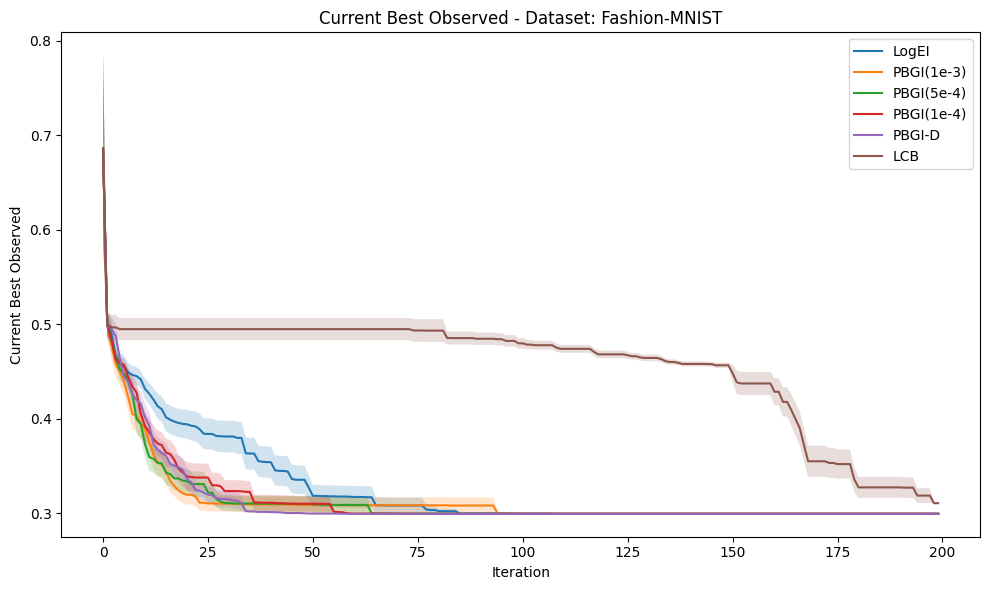

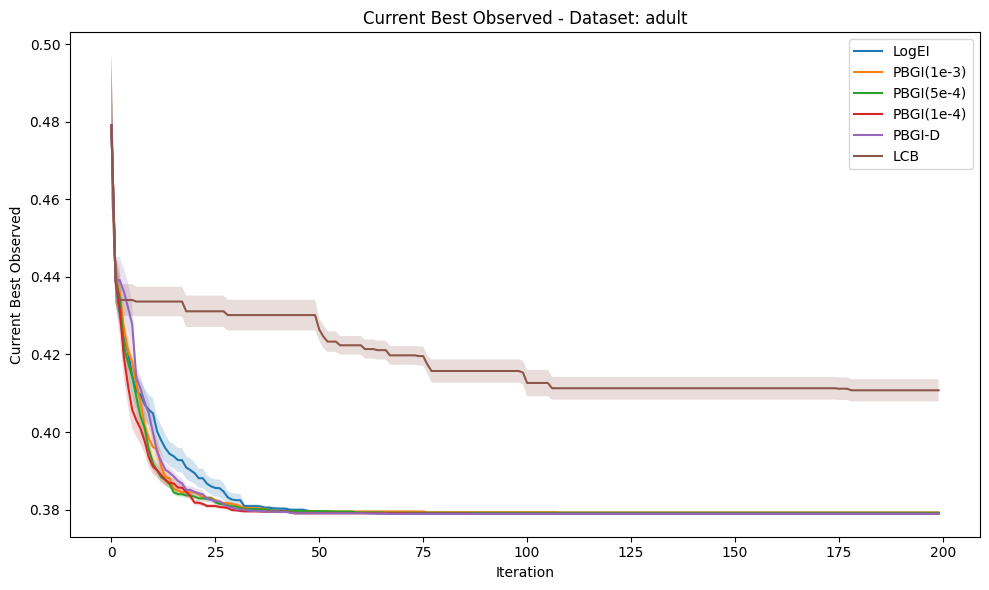

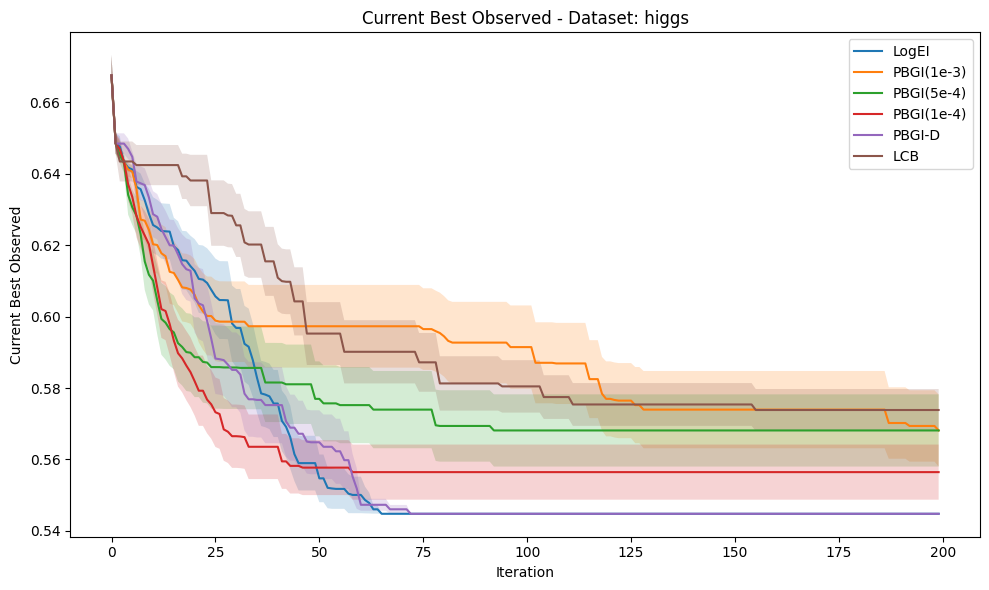

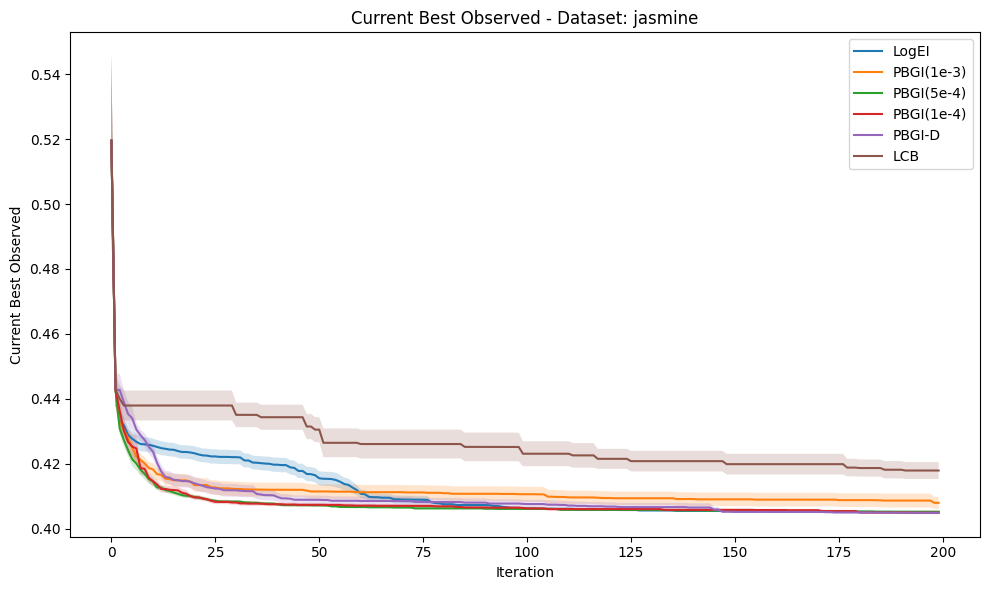

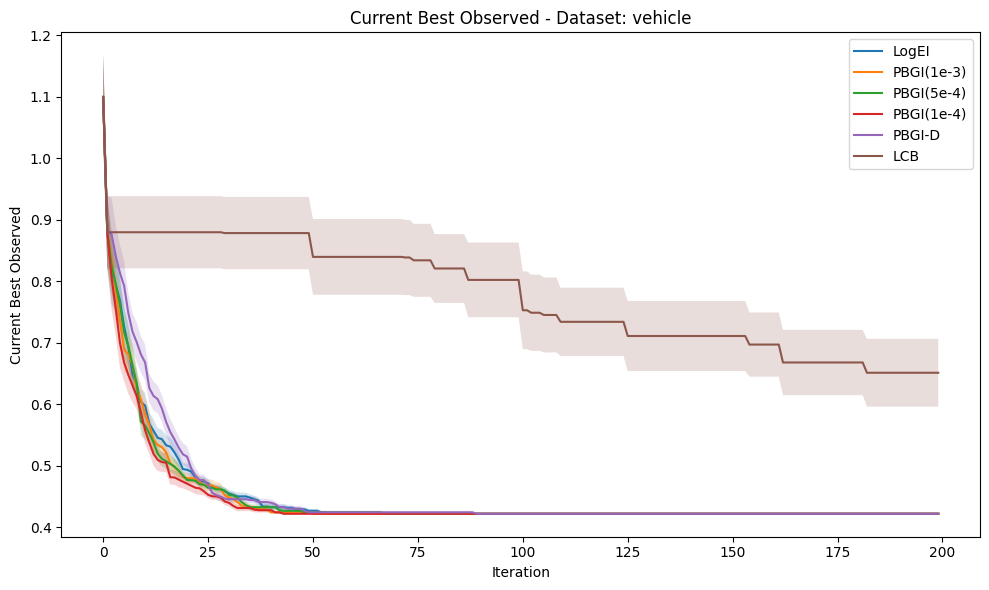

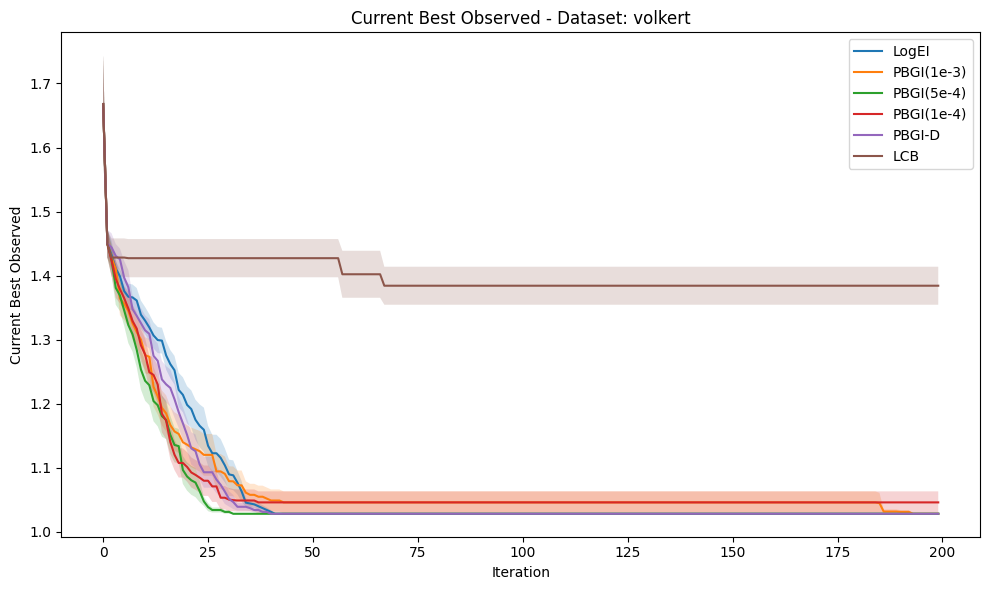

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Loop over each dataset to create one plot per dataset.
for d in dataset_names:
    plt.figure(figsize=(10, 6))
    
    # For each acquisition function in the dataset:
    for a in acquisition_functions:
        # Retrieve the current best observed data (assumed shape: [seeds, iterations])
        data = current_best_observed_per_acq[d][a]
        # Ensure it is a NumPy array (if not already)
        data = np.array(data)
        
        # Compute the mean and standard error (std/sqrt(n_seeds)) across seeds (axis=0)
        mean_curve = np.mean(data, axis=0)
        std_curve = np.std(data, axis=0)
        sem_curve = std_curve / np.sqrt(data.shape[0])
        
        # Create an x-axis corresponding to iterations
        iterations = np.arange(len(mean_curve))
        
        # Plot the mean curve
        plt.plot(iterations, mean_curve, label=a)
        # Add a shaded area for the standard error
        plt.fill_between(iterations, mean_curve - sem_curve, mean_curve + sem_curve, alpha=0.2)
    
    # Customize the plot
    plt.title(f"Current Best Observed - Dataset: {d}")
    plt.xlabel("Iteration")
    plt.ylabel("Current Best Observed")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [34]:
%%capture
from pprint import pprint
from LCBench.api import Benchmark
import os

os.makedirs("LCBench/cached", exist_ok=True)
bench_dir = "LCBench/cached/six_datasets_lw.json"
bench = Benchmark(bench_dir, cache=False)

In [48]:
from collections import defaultdict
import numpy as np

# Initialize dictionaries to hold the per-iteration test metrics for each dataset and acquisition function.
test_cross_entropy_per_acq = defaultdict(dict)
test_accuracy_per_acq = defaultdict(dict)

# Loop over each dataset and acquisition function.
for d in dataset_names:
    for a in acquisition_functions:
        # Assume config_id_per_acq[d][a] is a 2D array with shape (n_seeds, n_iterations)
        config_ids = config_id_per_acq[d][a]
        n_seeds, n_iterations = config_ids.shape
        
        # Prepare arrays to store the test metrics for each seed and each iteration.
        test_ce_mat = np.empty((n_seeds, n_iterations))
        test_acc_mat = np.empty((n_seeds, n_iterations))
        
        # Process each seed individually.
        for s in range(n_seeds):
            best_val = float('inf')
            best_config = None
            
            # For each iteration, update the best config seen so far based on validation cross entropy.
            for i in range(n_iterations):
                curr_config = config_ids[s, i]
                # Query the validation cross entropy for the current config.
                val = bench.query(d, "final_val_cross_entropy", curr_config)
                
                # If this config is better, update the best value and best configuration.
                if val < best_val:
                    best_val = val
                    best_config = curr_config
                
                # Use the best configuration so far to get test metrics.
                test_ce_mat[s, i] = bench.query(d, "final_test_cross_entropy", best_config)
                test_acc_mat[s, i] = bench.query(d, "final_test_accuracy", best_config)
        
        # Store the resulting matrices in the dictionaries.
        test_cross_entropy_per_acq[d][a] = test_ce_mat
        test_accuracy_per_acq[d][a] = test_acc_mat

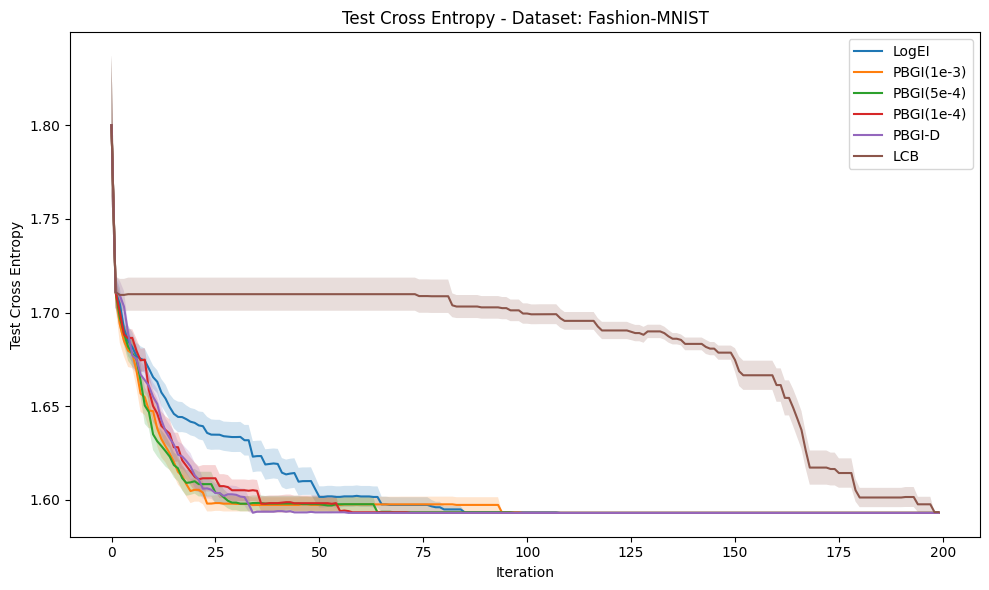

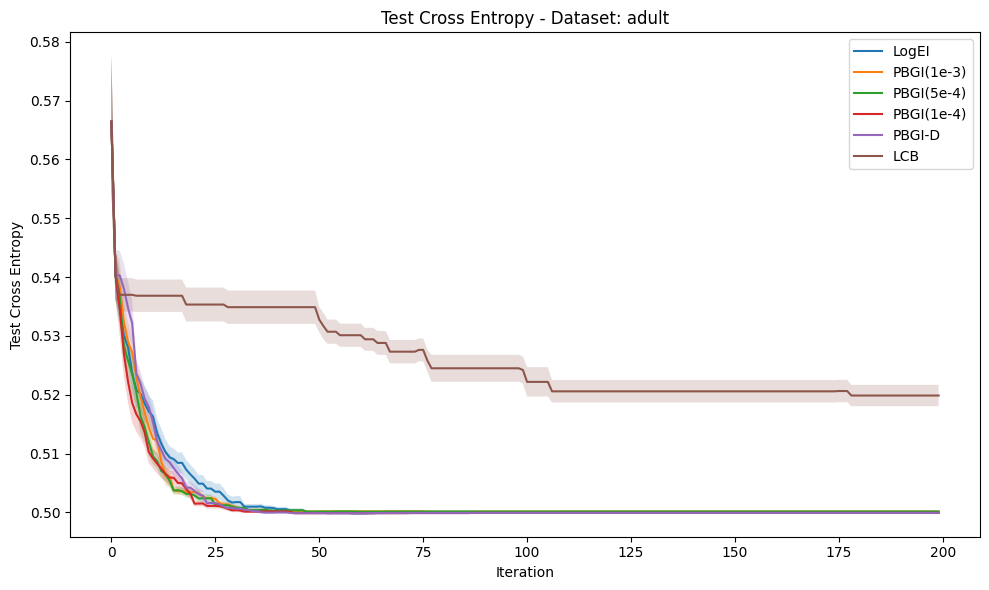

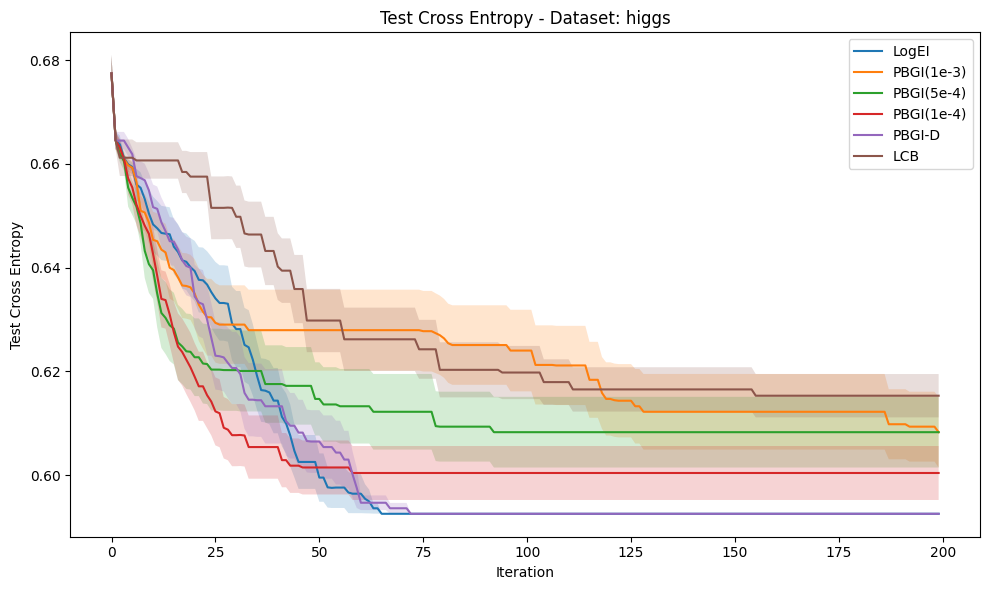

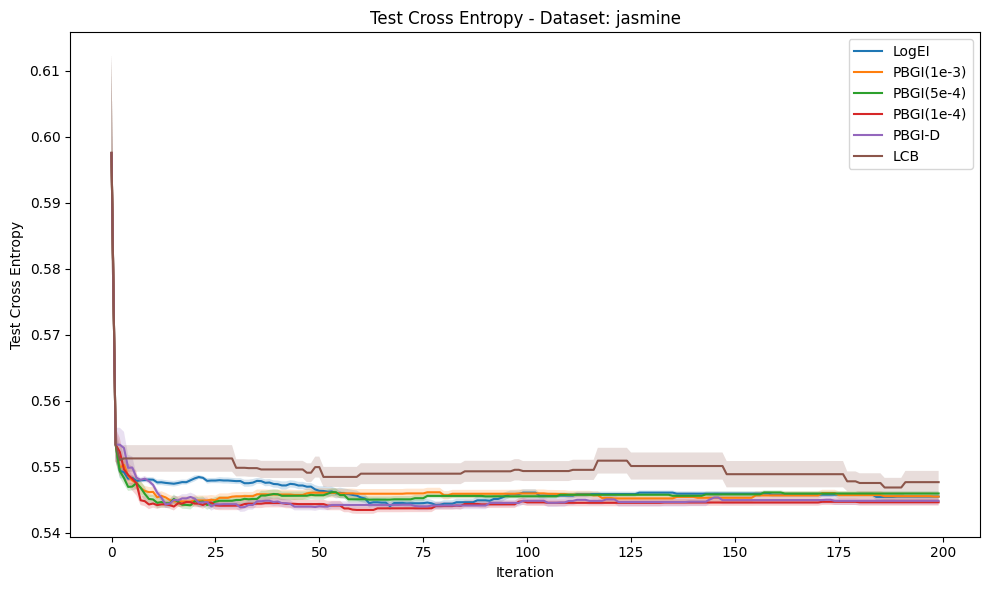

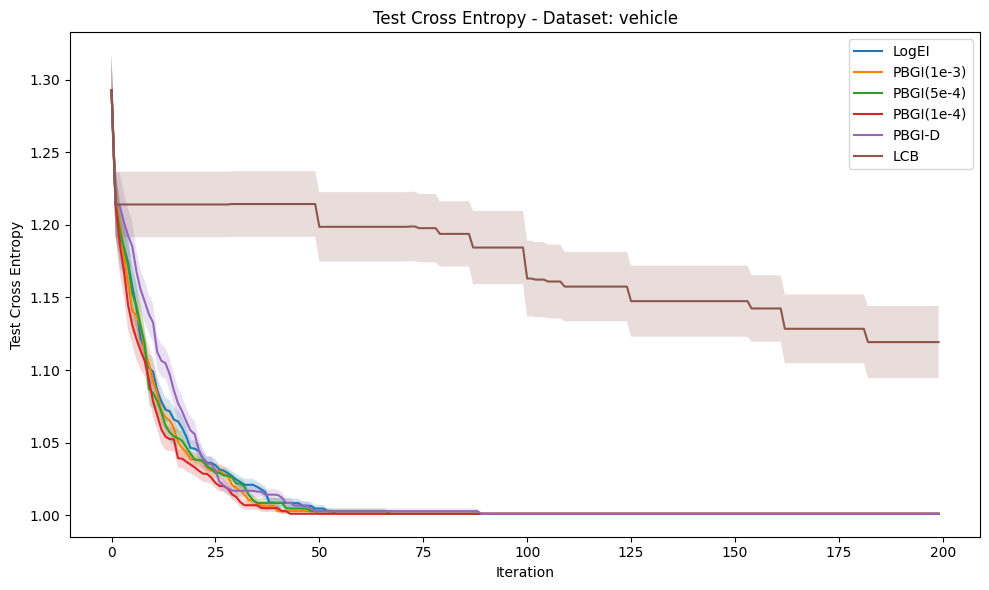

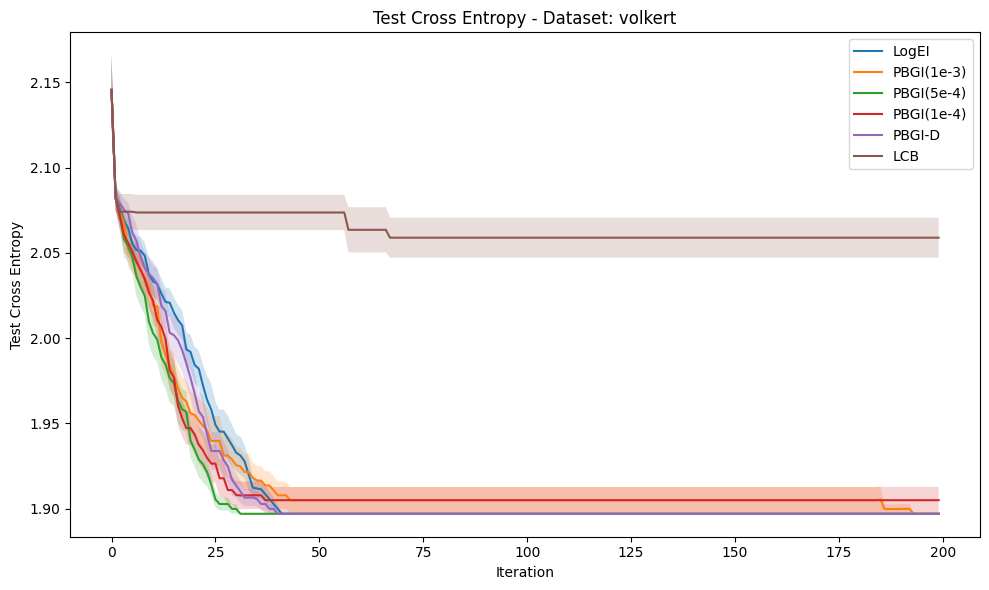

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Loop over each dataset to create one plot per dataset.
for d in dataset_names:
    plt.figure(figsize=(10, 6))
    
    # For each acquisition function in the dataset:
    for a in acquisition_functions:
        # Retrieve the test cross entropy data (assumed shape: [seeds, iterations])
        data = test_cross_entropy_per_acq[d][a]
        # Ensure it's a NumPy array
        data = np.array(data)
        
        # Compute the mean and standard error (std/sqrt(n_seeds)) across seeds (axis=0)
        mean_curve = np.mean(data, axis=0)
        std_curve = np.std(data, axis=0)
        sem_curve = std_curve / np.sqrt(data.shape[0])
        
        # Create an x-axis corresponding to iterations
        iterations = np.arange(len(mean_curve))
        
        # Plot the mean curve for the acquisition function
        plt.plot(iterations, mean_curve, label=a)
        # Add a shaded area for the standard error
        plt.fill_between(iterations, mean_curve - sem_curve, mean_curve + sem_curve, alpha=0.2)
    
    # Customize the plot
    plt.title(f"Test Cross Entropy - Dataset: {d}")
    plt.xlabel("Iteration")
    plt.ylabel("Test Cross Entropy")
    plt.legend()
    plt.tight_layout()
    plt.show()

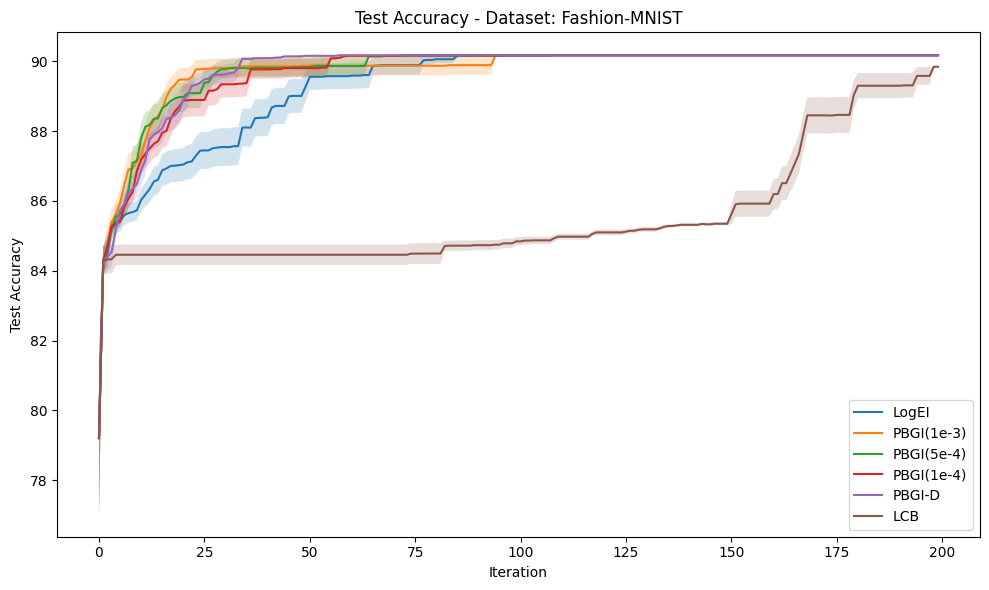

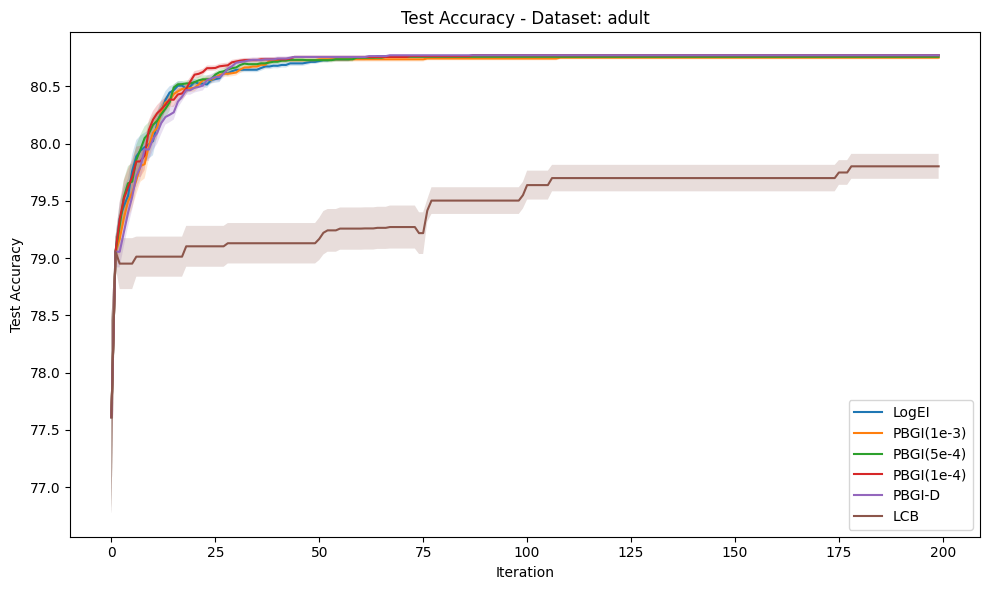

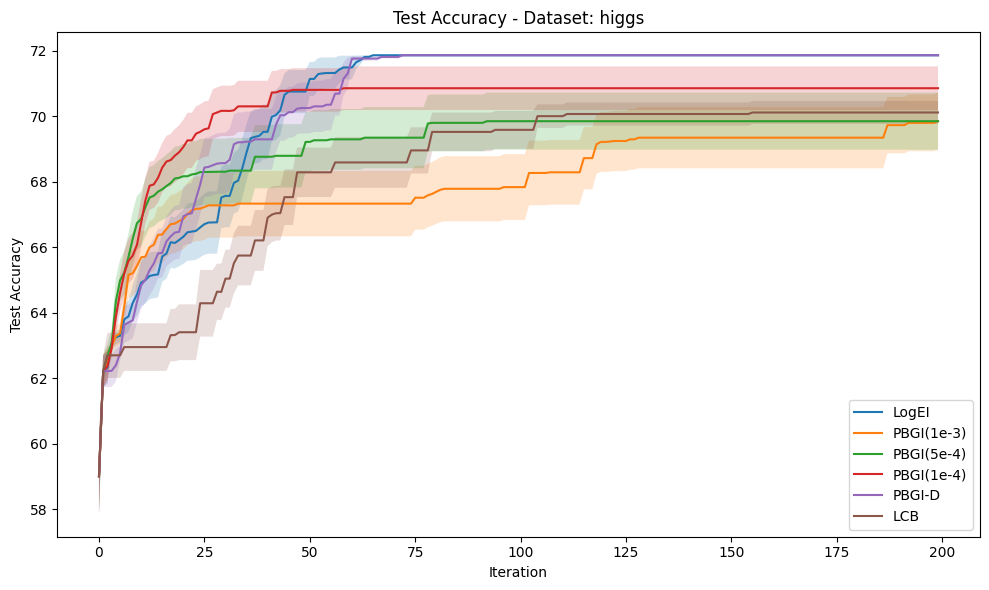

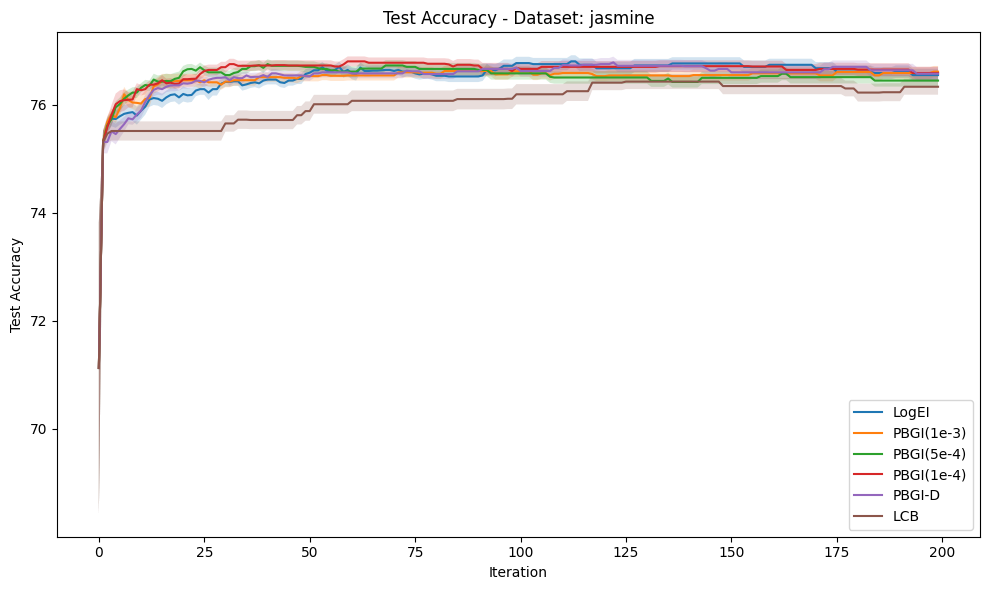

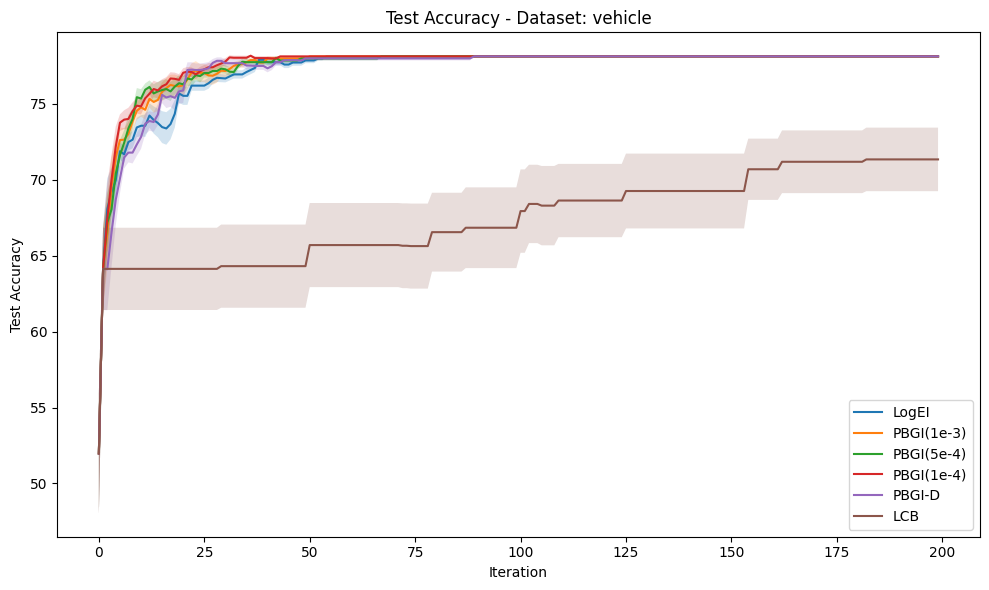

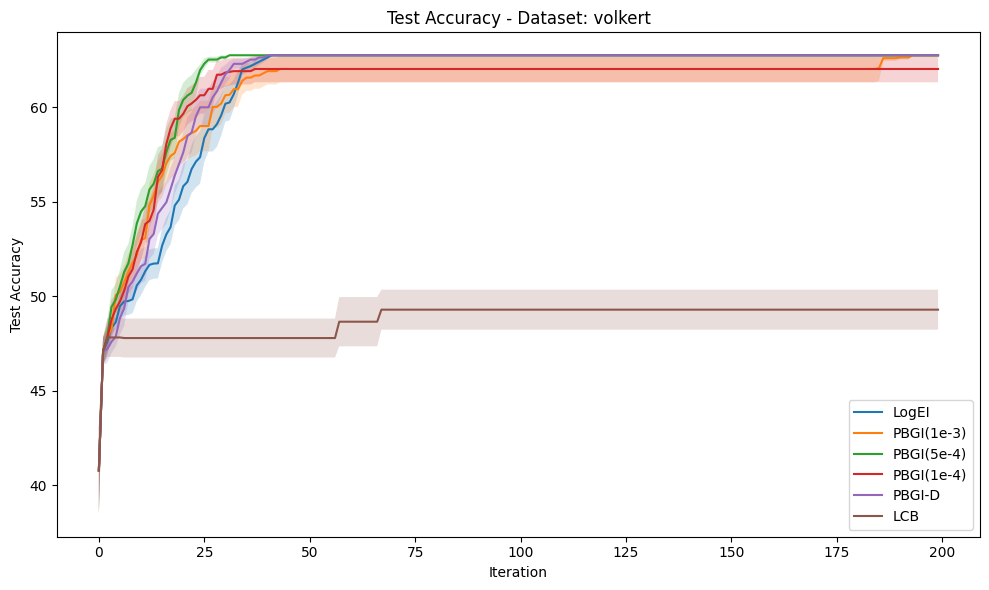

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Loop over each dataset to create one plot per dataset.
for d in dataset_names:
    plt.figure(figsize=(10, 6))
    
    # For each acquisition function in the dataset:
    for a in acquisition_functions:
        # Retrieve the test accuracy data (assumed shape: [seeds, iterations])
        data = test_accuracy_per_acq[d][a]
        # Ensure it is a NumPy array (if not already)
        data = np.array(data)
        
        # Compute the mean and standard error (std/sqrt(n_seeds)) across seeds (axis=0)
        mean_curve = np.mean(data, axis=0)
        std_curve = np.std(data, axis=0)
        sem_curve = std_curve / np.sqrt(data.shape[0])
        
        # Create an x-axis corresponding to iterations
        iterations = np.arange(len(mean_curve))
        
        # Plot the mean curve for the acquisition function
        plt.plot(iterations, mean_curve, label=a)
        # Add a shaded area for the standard error
        plt.fill_between(iterations, mean_curve - sem_curve, mean_curve + sem_curve, alpha=0.2)
    
    # Customize the plot
    plt.title(f"Test Accuracy - Dataset: {d}")
    plt.xlabel("Iteration")
    plt.ylabel("Test Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()